In [30]:
pip install --upgrade tensorflow-federated


  Using cached pandas-1.5.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.1 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.0
    Uninstalling pandas-2.2.0:
      Successfully uninstalled pandas-2.2.0
Note: you may need to restart the kernel to use updated packages.


In [1]:
!pip install --quiet --upgrade nest-asyncio
!pip install --quiet --upgrade pandas
!pip install --quiet --upgrade matplotlib

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-privacy 0.8.12 requires pandas~=1.4, but you have pandas 2.2.0 which is incompatible.


In [28]:
!pip install --upgrade pip

  Using cached pandas-1.5.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.1 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.0
    Uninstalling pandas-2.2.0:
      Successfully uninstalled pandas-2.2.0
Note: you may need to restart the kernel to use updated packages.


In [2]:
import collections
import os
import pandas as pd
import tensorflow as tf
import tensorflow_federated as tff
import time

from matplotlib import pyplot as plt

import nest_asyncio
nest_asyncio.apply()

%matplotlib inline

/tmp/ipykernel_3120/3403798242.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-13 11:15:34.567272: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-13 11:15:34.599234: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-13 11:15:34.599272: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT 

In [3]:
tp = 'cic'      # Type: choose between 'cic' and 'custom'
tm = 90        # Timeout: choose one value from the following list [15, 30, 60, 90, 120, 180]
n_workers = 2   # #workers: choose between 2 and 5 workers (2 and 5 inclusive)

In [4]:
df_train = pd.read_csv('/workspaces/Network_Intrusion_Detection/train_90_custom_script.csv')
df_test = pd.read_csv('/workspaces/Network_Intrusion_Detection/test_90_custom_script.csv')

In [5]:
df_train.dtypes

flow idle time max                                 float64
flow idle time min                                 float64
flow idle time mean                                float64
flow idle time std                                 float64
flow idle time variance                            float64
                                                    ...   
type_id_system_information_in_monitor_direction      int64
type_id_system_information_in_control_direction      int64
type_id_parameter_in_control_direction               int64
type_id_file_transfer                                int64
Label                                               object
Length: 112, dtype: object

In [6]:
df_test.dtypes

flow idle time max                                 float64
flow idle time min                                 float64
flow idle time mean                                float64
flow idle time std                                 float64
flow idle time variance                            float64
                                                    ...   
type_id_system_information_in_monitor_direction      int64
type_id_system_information_in_control_direction      int64
type_id_parameter_in_control_direction               int64
type_id_file_transfer                                int64
Label                                               object
Length: 112, dtype: object

In [7]:
df_train['Label'] = df_train['Label'].str.lower()
df_test['Label'] = df_test['Label'].str.lower()

In [8]:
unique_labels = list(df_train.Label.astype('category').unique())
unique_codes = list(df_train.Label.astype('category').cat.codes.unique())
mapping = {unique_codes[i] : unique_labels[i] for i in range(len(unique_labels))}

In [9]:
mapping

{11: 'normal',
 0: 'c_ci_na_1',
 1: 'c_ci_na_1_dos',
 2: 'c_rd_na_1',
 3: 'c_rd_na_1_dos',
 4: 'c_rp_na_1',
 5: 'c_rp_na_1_dos',
 6: 'c_sc_na_1',
 7: 'c_sc_na_1_dos',
 8: 'c_se_na_1',
 9: 'c_se_na_1_dos',
 10: 'm_sp_na_1_dos'}

In [10]:
df_train['Label'] = df_train['Label'].replace(unique_labels, unique_codes)
df_test['Label'] = df_test['Label'].replace(unique_labels, unique_codes)

/tmp/ipykernel_3120/3176878993.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train['Label'] = df_train['Label'].replace(unique_labels, unique_codes)
/tmp/ipykernel_3120/3176878993.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test['Label'] = df_test['Label'].replace(unique_labels, unique_codes)


In [11]:

train = df_train
test = df_test

In [12]:
n_samples = int(df_train.shape[0] / n_workers)

assert n_samples > 0, "Each worker must be assigned at least one data point"

In [13]:
n_epochs = 10
shuffle_buffer_size = df_train.shape[0]
batch_size = 250
prefetch_buffer_size = 50
input_shape = train.shape[1] - 1
output_shape = len(unique_codes)

In [14]:
def preprocess(dataframe):
    
    
    def map_fn(dataset):
        return collections.OrderedDict(
            x=tf.cast(dataset[:,:-1], tf.float64),
            y=tf.cast(tf.reshape(dataset[:,-1], shape=(-1, 1)), tf.int64)
        )

    return tf.data.Dataset.from_tensor_slices(dataframe).repeat(n_epochs).shuffle(
        shuffle_buffer_size).batch(batch_size).map(map_fn).prefetch(prefetch_buffer_size)


client_data = [preprocess(train.sample(n=n_samples)) for _ in range(n_workers)]

In [15]:
for i in range(n_workers):
    print(f"Worker {i+1} data contains {len(client_data[i])} training points")

Worker 1 data contains 102 training points
Worker 2 data contains 102 training points


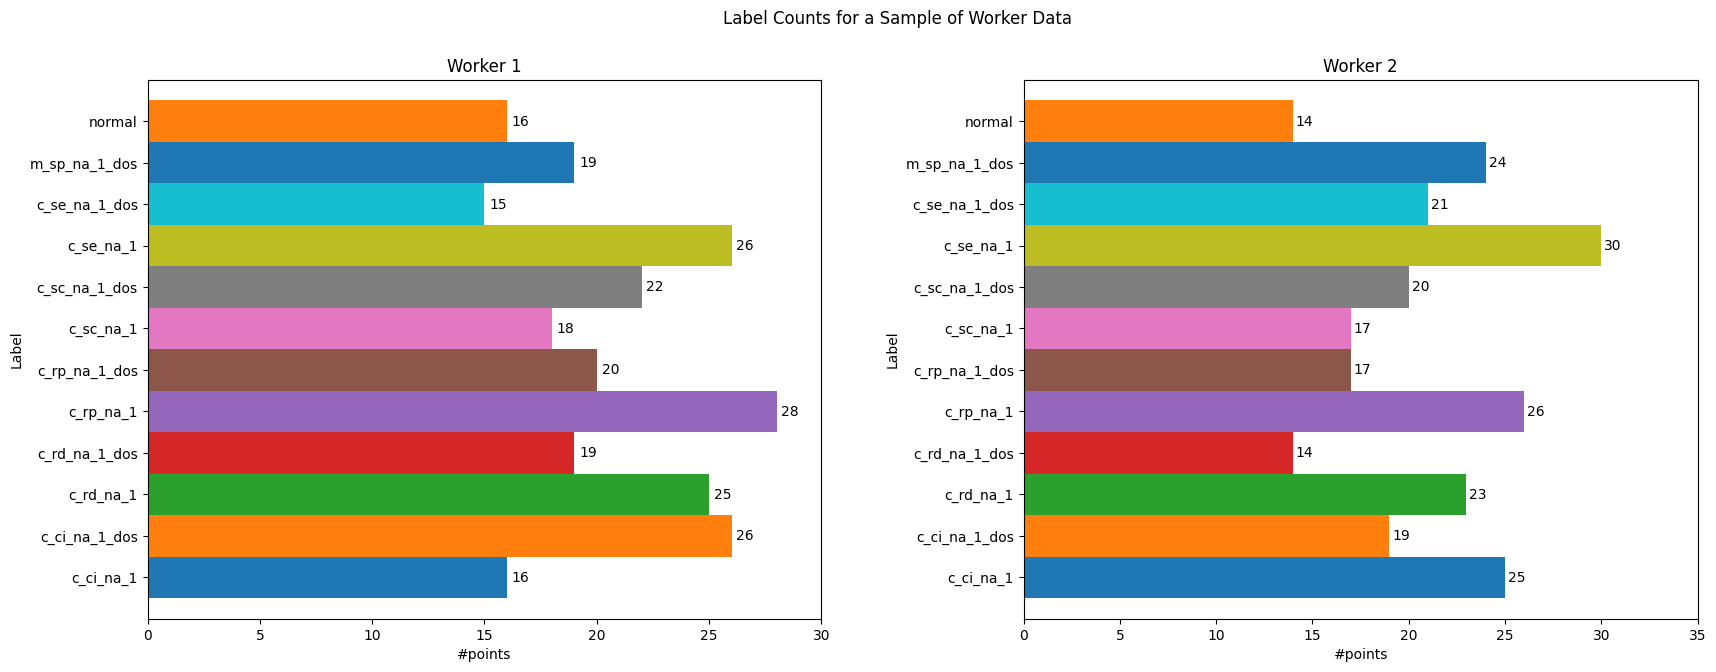

In [16]:
fig = plt.figure(figsize=(20, 7))
fig.suptitle('Label Counts for a Sample of Worker Data')
fig.tight_layout()

for i in range(n_workers):
    m = 0
    plot_data = collections.defaultdict(list)
    for label in list(client_data[i])[0]['y'].numpy()[:,0]:
        # Append counts individually per label to make plots
        # more colorful instead of one color per plot.
        plot_data[label].append(label)
        m = max(m, len(plot_data[label]))
    
    n_cols = n_workers if n_workers < 5 else 5
    xlim = [0, m+(5-m%5)]
    ylim = [min(unique_codes)-1, max(unique_codes)+1]
    yticks = list(range(min(unique_codes), max(unique_codes)+1))
    yticks_labels = [mapping[k] for k in range(0, max(unique_codes)+1)]
    
    plt.subplot(int(n_workers / 5)+1, n_cols, i+1)
    plt.subplots_adjust(wspace=0.3)
    plt.title('Worker {}'.format(i+1))
    plt.xlabel('#points')
    plt.xlim(xlim)
    plt.ylabel('Label')
    plt.ylim(ylim)
    plt.yticks(yticks, labels=yticks_labels)
    
    # plot values on top of bars
    for key in plot_data:
        if len(plot_data[key]) > 0:
            plt.text(len(plot_data[key])+0.6, int(key)-0.1, str(len(plot_data[key])), ha='center')
    
    for j in range(min(unique_codes),max(unique_codes)+1):
        plt.hist(
            plot_data[j],
            density=False,
            bins=[k-0.5 for k in range(min(unique_codes),max(unique_codes)+2)],
            orientation='horizontal'
        )

In [20]:
# def model_fn():
#     model = tf.keras.models.Sequential([
#         tf.keras.layers.InputLayer(input_shape=(input_shape,)),
#         tf.keras.layers.Dense(output_shape, kernel_initializer='zeros', activation='relu'),
#         tf.keras.layers.Softmax(),
#     ])

#     return tff.learning.from_compiled_keras_model(model,
#         # Note: input spec is the _batched_ shape, and includes the 
#         # label tensor which will be passed to the loss function. This model is
#         # therefore configured to accept data _after_ it has been preprocessed.
#         input_spec=collections.OrderedDict(
#             x=tf.TensorSpec(shape=[None, input_shape], dtype=tf.float64),
#             y=tf.TensorSpec(shape=[None, 1], dtype=tf.int64)),
#         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#         metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])


In [21]:
# def model_fn():
#     model = tf.keras.models.Sequential([
#         tf.keras.layers.InputLayer(input_shape=(input_shape,)),
#         tf.keras.layers.Dense(output_shape, kernel_initializer='zeros', activation='relu'),
#         tf.keras.layers.Softmax(),
#     ])
#     return tff.learning.from_keras_model(
#         model,
#         input_spec=collections.OrderedDict(
#             x=tf.TensorSpec(shape=[None, input_shape], dtype=tf.float64),
#             y=tf.TensorSpec(shape=[None, 1], dtype=tf.int64)),
#         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#         metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [19]:
def model_fn():
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(input_shape,)),
        tf.keras.layers.Dense(output_shape, kernel_initializer='zeros', activation='relu'),
        tf.keras.layers.Softmax(),
    ])

    # Specify input spec (batched shape) and label tensor
    input_spec = collections.OrderedDict(
        x=tf.TensorSpec(shape=[None, input_shape], dtype=tf.float64),
        y=tf.TensorSpec(shape=[None, 1], dtype=tf.int64))

    # Convert Keras model to TFF functional model
    tff_model = tff.learning.models.from_keras_model(
        keras_model=model,
        input_spec=input_spec,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

    return tff_model

# Build the weighted federated averaging trainer
trainer = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.01),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0)
)

In [20]:
print(trainer.initialize.type_signature.formatted_representation())

( -> <
  global_model_weights=<
    trainable=<
      float32[111,12],
      float32[12]
    >,
    non_trainable=<>
  >,
  distributor=<>,
  client_work=<>,
  aggregator=<
    value_sum_process=<>,
    weight_sum_process=<>
  >,
  finalizer=<
    int64,
    float32[111,12],
    float32[12]
  >
>@SERVER)


In [27]:
def evaluate(num_rounds=10):    
    state = trainer.initialize()
    for round in range(num_rounds):
        t1 = time.time()
        result = trainer.next(state, client_data)
        state = result.state
        train_metrics = result.metrics['client_work']['train']
        accuracy = train_metrics.pop('accuracy')
        t2 = time.time()
        print('Round {}: loss {}, accuracy {}, round time {}'.format(
            round+1, train_metrics['loss'], accuracy, t2 - t1))

In [28]:
import grpc
ip_address = ['0.0.0.0'] * n_workers  #@param {type:"string"}
ports = [80+i for i in range(n_workers)]  #@param {type:list["integer"]}

channels = [grpc.insecure_channel(f'{ip_address[i]}:{ports[i]}') for i in range(len(ports))]

tff.backends.native.set_sync_local_cpp_execution_context(channels)

In [29]:
evaluate(n_epochs)

2024-02-13 11:50:45.610410: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-02-13 11:50:45.610516: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2024-02-13 11:50:45.622034: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-02-13 11:50:45.622125: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session


KeyboardInterrupt: 

In [30]:
tf.test.gpu_device_name()

''